<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
# Importar librerias
import random
import io
import pickle
import re

import numpy as np
import pandas as pd

from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

import matplotlib.pyplot as plt
import seaborn as sns

### 1 - Datos

In [2]:
# Leo el libro del archivo txt (Se combino los 3 volumenes del libro "GENERAL ANATOMY,APPLIED TOPHYSIOLOGY AND MEDICINE" de Xavier Bichat en un solo archivo txt)
with open('book.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Separo el texto en oraciones, las cuales se separan mediante un punto ('.')
sentences = text.split('.')

# Creo un dataframe que contiene las oraciones
df = pd.DataFrame({'Oracion': sentences})

df.head()

,Oracion
0,", VOL 1 ***\n\n\n\n\n\n\n\n\n\nProduced by Son..."
1,pgdp
2,net (This\n\nfile was produced from images gen...
3,"X\n\n\n\n_Published by Richardson & Lord, Boston"
4,_]\n\n\n\n\n\n\n\n\n\n ...


In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 19184


### 2 - Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [4]:
# Preprocesamiento: filtro números, espacios en blanco consecutivos y caractéres especiales
book = [re.sub(r'[^a-zA-z.!?/\"\'\s]', ' ', sentence) for sentence in df['Oracion']]
book = [re.sub(r'\s+', ' ', sentence) for sentence in book]
book = [re.sub(r'[\_\[\]]', '',sentence) for sentence in book]
book = [sentence.lower() for sentence in book]

##### 2.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [5]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
# Entran oraciones y salen vectores de N posiciones (tokens)
sentence_tokens = [text_to_word_sequence(sentence) for sentence in book]
# Analizo como tokeniza la oración numero 6000
sentence_tokens[6000]

['this',
 'influence',
 'is',
 'not',
 'however',
 'such',
 'as',
 'boerhaave',
 'thought',
 'that',
 'the',
 'circulation',
 'could',
 'not',
 'go',
 'on',
 'without',
 'it']

In [7]:
# Largo de la secuencia: incluye seq input + word output
train_len = 4

# Desfasaje de palabras según el train_len
text_sequences = []

for sentence in sentence_tokens:
    if len(sentence) >= train_len:
        for i in range(train_len, len(sentence) + 1):
            seq = sentence[i - train_len : i]
            text_sequences.append(seq)

print(f'Cantidad de secuencias: {len(text_sequences)}')

Cantidad de secuencias: 362229


In [8]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[4500:4510]

[['of', 'the', 'vital', 'forces'],
 ['the', 'vital', 'forces', 'to'],
 ['vital', 'forces', 'to', 'the'],
 ['forces', 'to', 'the', 'natural'],
 ['to', 'the', 'natural', 'type'],
 ['the', 'natural', 'type', 'from'],
 ['natural', 'type', 'from', 'which'],
 ['type', 'from', 'which', 'they'],
 ['from', 'which', 'they', 'have'],
 ['which', 'they', 'have', 'been']]

##### 2.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [9]:
tok = Tokenizer() 
# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = np.array(tok.texts_to_sequences(text_sequences))


In [10]:
# Cantidad de veces que aparece cada palabra
print(f'Tamaño del vocabulario: {len(tok.word_counts)}\n')
# Cantidad de casos (doc) de entrada
print(f'Cantidad de documentos de entrada:{tok.document_count}')

Tamaño del vocabulario: 7830

Cantidad de documentos de entrada:362229


In [11]:
total_words = len(tok.index_word)+1

### 3 - Input y target

In [12]:
X = sequences[:, :-1] # todos los rows, menos la ultima col
y = sequences[:, -1] # última col de cada row
    
print(f'\nTamaño de entrada: {X.shape}')
print(f'Tamaño de salida: {y.shape}')


Tamaño de entrada: (362229, 3)
Tamaño de salida: (362229,)


In [13]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(362229, 3)
(362229,)


In [14]:
y = to_categorical(y-1, num_classes = total_words)


In [15]:
y.shape

(362229, 7831)

### 4 - Entrenar el modelo

In [16]:
# Largo de la secuencia de entrada
input_seq_len = X.shape[1] 
# Largo del vector de salida 
output_size = total_words

In [17]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim = total_words, 
                    output_dim = 5, 
                    input_length = input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(output_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              39155     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 7831)              258423    
                                                                 
Total params: 350602 (1.34 MB)
Trainable params: 350602 

In [17]:
model2 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model2.add(Embedding(input_dim = total_words, 
                    output_dim = 5, 
                    input_length = input_seq_len))

model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model2.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model2.add(Dense(output_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              39155     
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)            

In [18]:
model3 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model3.add(Embedding(input_dim = total_words, 
                    output_dim = 5, 
                    input_length = input_seq_len))

model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(128)) # La última capa LSTM no lleva return_sequences
model3.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model3.add(Dense(output_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 5)              39155     
                                                                 
 lstm_6 (LSTM)               (None, 3, 128)            68608     
                                                                 
 dropout_4 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 3, 128)            131584    
                                                                 
 dropout_5 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_8 (LSTM)               (None, 3, 128)            131584    
                                                                 
 dropout_6 (Dropout)         (None, 3, 128)           

In [18]:
def training_model(model, X, y):
    
    for i in range(1,3):

        # Entranamos el modelo
        hist = model.fit(X, y, epochs=5*i, validation_split=0.2)
        # Grafico de los resultados
        epoch_count = range(1, len(hist.history['accuracy']) + 1)
        sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
        sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
        plt.show()

    return

Epoch 1/5
9056/9056 [==============================] - 82s 9ms/step - loss: 5.8210 - accuracy: 0.1281 - val_loss: 5.6666 - val_accuracy: 0.1403
Epoch 2/5
9056/9056 [==============================] - 64s 7ms/step - loss: 5.2992 - accuracy: 0.1584 - val_loss: 5.4577 - val_accuracy: 0.1722
Epoch 3/5
9056/9056 [==============================] - 62s 7ms/step - loss: 5.0482 - accuracy: 0.1826 - val_loss: 5.3263 - val_accuracy: 0.1874
Epoch 4/5
9056/9056 [==============================] - 62s 7ms/step - loss: 4.8757 - accuracy: 0.1957 - val_loss: 5.2574 - val_accuracy: 0.1967
Epoch 5/5
9056/9056 [==============================] - 64s 7ms/step - loss: 4.7593 - accuracy: 0.2046 - val_loss: 5.2360 - val_accuracy: 0.2017


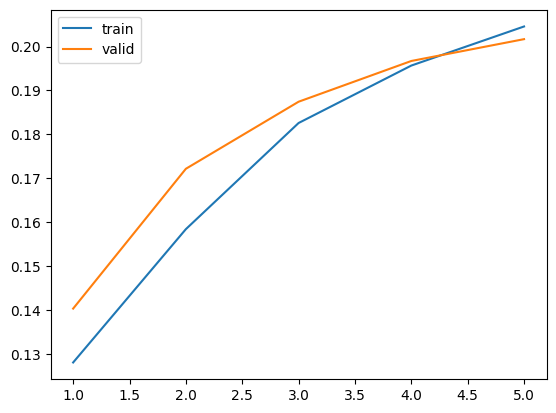

Epoch 1/10
9056/9056 [==============================] - 71s 8ms/step - loss: 4.6772 - accuracy: 0.2106 - val_loss: 5.2090 - val_accuracy: 0.2063
Epoch 2/10
9056/9056 [==============================] - 62s 7ms/step - loss: 4.6176 - accuracy: 0.2148 - val_loss: 5.2203 - val_accuracy: 0.2093
Epoch 3/10
9056/9056 [==============================] - 62s 7ms/step - loss: 4.5730 - accuracy: 0.2176 - val_loss: 5.2022 - val_accuracy: 0.2104
Epoch 4/10
9056/9056 [==============================] - 63s 7ms/step - loss: 4.5360 - accuracy: 0.2199 - val_loss: 5.2309 - val_accuracy: 0.2128
Epoch 5/10
9056/9056 [==============================] - 71s 8ms/step - loss: 4.5060 - accuracy: 0.2226 - val_loss: 5.1862 - val_accuracy: 0.2126
Epoch 6/10
9056/9056 [==============================] - 66s 7ms/step - loss: 4.4814 - accuracy: 0.2249 - val_loss: 5.2003 - val_accuracy: 0.2142
Epoch 7/10
9056/9056 [==============================] - 67s 7ms/step - loss: 4.4615 - accuracy: 0.2263 - val_loss: 5.1949 - val_ac

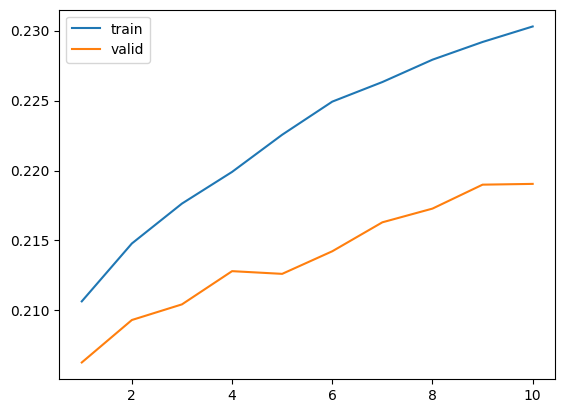

In [19]:
training_model(model, X, y)

Epoch 1/5
9057/9057 [==============================] - 131s 14ms/step - loss: 5.8557 - accuracy: 0.1295 - val_loss: 5.6941 - val_accuracy: 0.1468
Epoch 2/5
9057/9057 [==============================] - 124s 14ms/step - loss: 5.3566 - accuracy: 0.1580 - val_loss: 5.5295 - val_accuracy: 0.1639
Epoch 3/5
9057/9057 [==============================] - 116s 13ms/step - loss: 5.1976 - accuracy: 0.1656 - val_loss: 5.4815 - val_accuracy: 0.1695
Epoch 4/5
9057/9057 [==============================] - 116s 13ms/step - loss: 5.0906 - accuracy: 0.1734 - val_loss: 5.4501 - val_accuracy: 0.1761
Epoch 5/5
9057/9057 [==============================] - 116s 13ms/step - loss: 5.0047 - accuracy: 0.1793 - val_loss: 5.4152 - val_accuracy: 0.1819


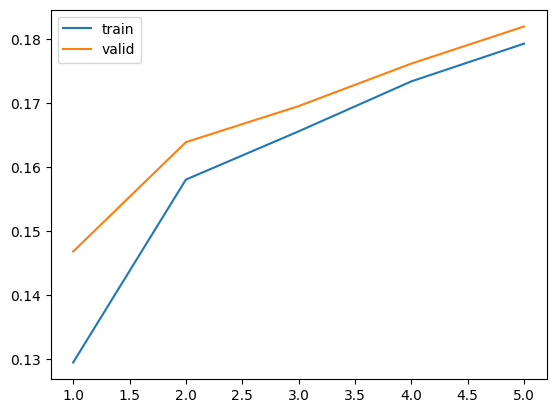

Epoch 1/10
9057/9057 [==============================] - 122s 13ms/step - loss: 4.9351 - accuracy: 0.1841 - val_loss: 5.3973 - val_accuracy: 0.1842
Epoch 2/10
9057/9057 [==============================] - 118s 13ms/step - loss: 4.8790 - accuracy: 0.1882 - val_loss: 5.3535 - val_accuracy: 0.1888
Epoch 3/10
9057/9057 [==============================] - 117s 13ms/step - loss: 4.8335 - accuracy: 0.1916 - val_loss: 5.3425 - val_accuracy: 0.1919
Epoch 4/10
9057/9057 [==============================] - 118s 13ms/step - loss: 4.7946 - accuracy: 0.1948 - val_loss: 5.3295 - val_accuracy: 0.1939
Epoch 5/10
9057/9057 [==============================] - 117s 13ms/step - loss: 4.7649 - accuracy: 0.1978 - val_loss: 5.3179 - val_accuracy: 0.1965
Epoch 6/10
9057/9057 [==============================] - 116s 13ms/step - loss: 4.7378 - accuracy: 0.1996 - val_loss: 5.2934 - val_accuracy: 0.1966
Epoch 7/10
9057/9057 [==============================] - 116s 13ms/step - loss: 4.7155 - accuracy: 0.2014 - val_loss: 5

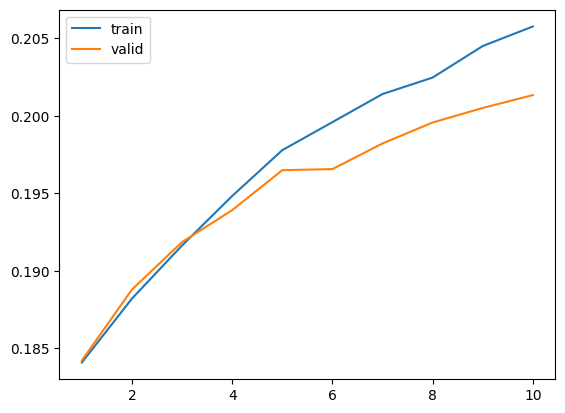

In [21]:
training_model(model2, X, y)

Epoch 1/5
9057/9057 [==============================] - 212s 23ms/step - loss: 5.7299 - accuracy: 0.1334 - val_loss: 5.5773 - val_accuracy: 0.1518
Epoch 2/5
9057/9057 [==============================] - 196s 22ms/step - loss: 5.2546 - accuracy: 0.1589 - val_loss: 5.4162 - val_accuracy: 0.1700
Epoch 3/5
9057/9057 [==============================] - 192s 21ms/step - loss: 5.0318 - accuracy: 0.1762 - val_loss: 5.3169 - val_accuracy: 0.1819
Epoch 4/5
9057/9057 [==============================] - 175s 19ms/step - loss: 4.8890 - accuracy: 0.1867 - val_loss: 5.2943 - val_accuracy: 0.1900
Epoch 5/5
9057/9057 [==============================] - 171s 19ms/step - loss: 4.7930 - accuracy: 0.1927 - val_loss: 5.2732 - val_accuracy: 0.1930


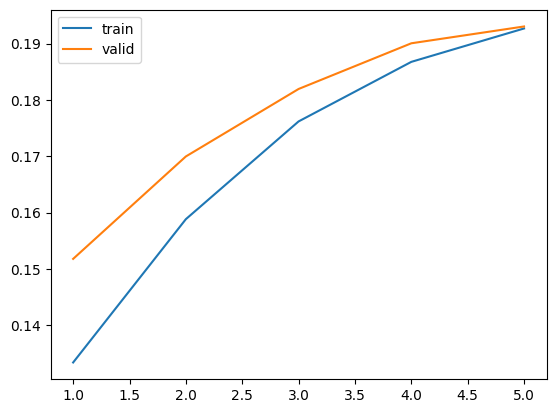

Epoch 1/10
9057/9057 [==============================] - 192s 21ms/step - loss: 4.7223 - accuracy: 0.1973 - val_loss: 5.2450 - val_accuracy: 0.1973
Epoch 2/10
9057/9057 [==============================] - 169s 19ms/step - loss: 4.6657 - accuracy: 0.2018 - val_loss: 5.2355 - val_accuracy: 0.2000
Epoch 3/10
9057/9057 [==============================] - 171s 19ms/step - loss: 4.6158 - accuracy: 0.2062 - val_loss: 5.2395 - val_accuracy: 0.2019
Epoch 4/10
9057/9057 [==============================] - 172s 19ms/step - loss: 4.5756 - accuracy: 0.2092 - val_loss: 5.2284 - val_accuracy: 0.2060
Epoch 5/10
9057/9057 [==============================] - 169s 19ms/step - loss: 4.5402 - accuracy: 0.2125 - val_loss: 5.2188 - val_accuracy: 0.2074
Epoch 6/10
9057/9057 [==============================] - 170s 19ms/step - loss: 4.5120 - accuracy: 0.2142 - val_loss: 5.2188 - val_accuracy: 0.2076
Epoch 7/10
9057/9057 [==============================] - 171s 19ms/step - loss: 4.4852 - accuracy: 0.2166 - val_loss: 5

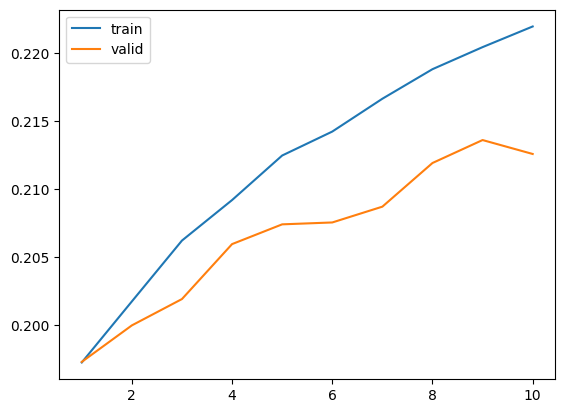

In [21]:
training_model(model3, X, y)

### 5 - Predicción de próxima palabra

In [50]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

In [60]:
model_response("the heart has")

1/1 [==============================] - 0s 19ms/step


'the heart has mucous'

In [52]:
model_response("the pulmonary veins")

1/1 [==============================] - 0s 25ms/step


'the pulmonary veins to'

In [53]:
model_response("the aorta is")

1/1 [==============================] - 0s 20ms/step


'the aorta is from'

In [54]:
model_response("when the blood")

1/1 [==============================] - 0s 19ms/step


'when the blood in'

### 6 - Generación de secuencias nuevas

In [61]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [62]:
input_text="the blood is"

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 19ms/step


'the blood is from '

In [63]:
input_text="the ventricle with"

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 19ms/step


'the ventricle with it   '

### 7 - Conclusiones
El modelo entrenado mostró un rendimiento deficiente durante el entrenamiento, los resultados obtenidos no muestran mucho sentido logico. 

Se realizaron varios cambios en el modelo para tratar de solucionar dicho problema. En primer lugar, se opto por un un modelo con mas capas (modelo2) y posteriormente por otro (modelo3) con mas neuronas. Tambien se modifico el numero de epocas (5, 10) para ver su impacto en el rendimiento. Lamentablemente, ninguna de estas combinaciones logró obtener una precisión superior al 0.2.

Como para este ejercicio se utilizaron embeddings personalizados para entrenar los modelos, se puede llegar a sacar como conclusion que se requiere un corpus de datos mas grande para mejorar las metricas y resultados.